 The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

Content
Historical Product Demand.csv - CSV data file containing product demand for encoded product id's

Acknowledgements
This dataset is all real-life data and products/warehouse and category information encoded.

Inspiration
Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [3]:
df = pd.read_csv('Historical_Product_Demand.csv')

In [4]:
df.head(2)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500


## Describes type data, number of values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1048575 non-null object
Warehouse           1048575 non-null object
Product_Category    1048575 non-null object
Date                1037336 non-null object
Order_Demand        1048575 non-null object
dtypes: object(5)
memory usage: 40.0+ MB


In [6]:
df.describe(include='all')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [7]:
df.loc[df['Date'].isnull()].head() # check null values in Date

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200


In [8]:
df.dropna(inplace=True) # drop rows with NULL

In [9]:
df.duplicated().sum() # check duplicates

113064

In [10]:
df.drop_duplicates(inplace = True) # drop duplicates 

In [11]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime

In [12]:
df = df[pd.to_numeric(df["Order_Demand"],errors='coerce').notnull()] # exclude non-numeric values

In [13]:
df["Order_Demand"] = pd.to_numeric(df["Order_Demand"]) # convert Order_Demand to numeric

In [14]:
df['Order_Demand'].max() # max value of Order_Demand

4000000

In [15]:
df['Order_Demand'].min() # min value of Order_Demand

0

In [16]:
df["Date"].max() # max value of Date

Timestamp('2017-01-09 00:00:00')

In [17]:
df["Date"].min() # min value of Date

Timestamp('2011-01-08 00:00:00')

In [18]:
df["Order_Demand"].value_counts().reset_index().sort_values(by = ['index']) # check the range of order demands

,index,Order_Demand
14,0,19639
2,1,51474
9,2,32830
15,3,17198
18,4,13062
...,...,...
1976,2300000,1
1012,2500000,5
2856,2560000,1
1392,3000000,3


In [19]:
df["month_year"] = df["Date"].astype('datetime64[M]') # create new column date crop to month level

In [20]:
df['Year'] = df['Date'].dt.year # create new column date crop to year level

## Contribution of order demand by product category

In [21]:
df1 = pd.DataFrame(df.groupby('Product_Category')['Order_Demand'].sum().sort_values(ascending=False))
df1["% Contribution"] = df1['Order_Demand']/df1['Order_Demand'].sum()*100
df1

,Order_Demand,% Contribution
Product_Category,,
Category_019,3858939177,81.805627
Category_006,392614853,8.323040
Category_005,188960830,4.005779
Category_007,122073020,2.587825
Category_028,47515424,1.007279
Category_033,40680000,0.862375
Category_030,39797903,0.843675
Category_021,4352875,0.092277
Category_032,4320086,0.091581


The first 5 categories covers 97% of order demands

### Top products by order demands

In [22]:
df2 = df.merge(df.groupby(['Product_Category','Warehouse'])['Order_Demand'].\
               sum().sort_values(ascending=False).head(5), on=['Product_Category','Warehouse'])
# top 5 products by Order Demand

In [23]:
df2.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand_x,month_year,Year,Order_Demand_y
0,Product_1159,Whse_J,Category_006,2012-01-06,50000,2012-01-01,2012,308205603
1,Product_1159,Whse_J,Category_006,2012-01-18,100000,2012-01-01,2012,308205603
2,Product_1159,Whse_J,Category_006,2012-02-02,50000,2012-02-01,2012,308205603
3,Product_1159,Whse_J,Category_006,2012-02-22,50000,2012-02-01,2012,308205603
4,Product_1159,Whse_J,Category_006,2012-03-02,50000,2012-03-01,2012,308205603


In [24]:
df_top_products = df2[['Order_Demand_x','Warehouse','month_year','Product_Category']][df2['month_year']>='2015-01'].groupby(['Warehouse','month_year','Product_Category'])\
.agg(['sum']).reset_index()
# top 5 products by order demand aggregated by month

In [25]:
df_top_products.head()

,Warehouse,month_year,Product_Category,Order_Demand_x
,,,,sum
0,Whse_C,2015-01-01,Category_019,10431729
1,Whse_C,2015-02-01,Category_019,5449522
2,Whse_C,2015-03-01,Category_019,8552706
3,Whse_C,2015-04-01,Category_019,9198058
4,Whse_C,2015-05-01,Category_019,6812235


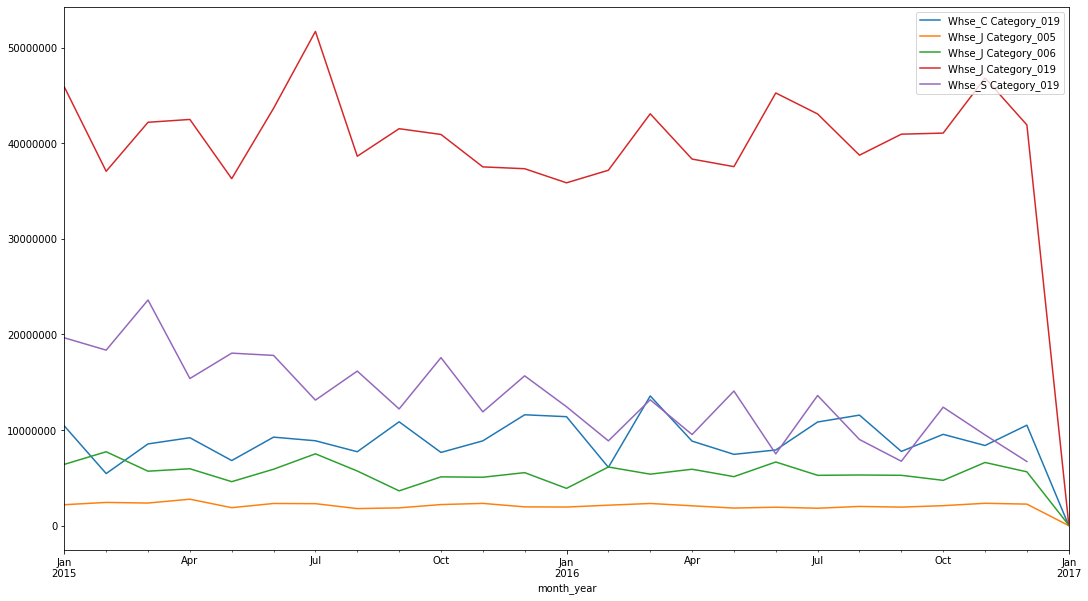

In [26]:
fig, ax =plt.subplots(figsize=(18,10))
for x,y in df_top_products.groupby(['Warehouse','Product_Category']):
    y.plot(x='month_year', y=('Order_Demand_x','sum'), ax=ax, label=' '.join(x))
    ax.legend(loc='upper right')
    ax.ticklabel_format(axis = 'y', style = 'plain')

In [27]:
df['Product_Code'].unique()

array(['Product_0993', 'Product_0979', 'Product_1159', ...,
       'Product_0237', 'Product_0644', 'Product_0853'], dtype=object)

In [28]:
df['Warehouse'].unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [29]:
df['Product_Category'].unique()

array(['Category_028', 'Category_006', 'Category_001', 'Category_019',
       'Category_005', 'Category_030', 'Category_032', 'Category_011',
       'Category_033', 'Category_007', 'Category_015', 'Category_021',
       'Category_024', 'Category_026', 'Category_023', 'Category_022',
       'Category_009', 'Category_003', 'Category_004', 'Category_018',
       'Category_020', 'Category_013', 'Category_008', 'Category_017',
       'Category_031', 'Category_025', 'Category_010', 'Category_029',
       'Category_012', 'Category_002', 'Category_014', 'Category_027',
       'Category_016'], dtype=object)

### Order demands by years and warehouses

In [30]:
df3 = df[['Year', 'Warehouse', 'Order_Demand']].groupby(['Year', 'Warehouse'], as_index=False).count()

In [31]:
df3.head(10)

,Year,Warehouse,Order_Demand
0,2011,Whse_A,127
1,2011,Whse_C,134
2,2011,Whse_J,170
3,2011,Whse_S,143
4,2012,Whse_A,26169
5,2012,Whse_C,6775
6,2012,Whse_J,127651
7,2012,Whse_S,18104
8,2013,Whse_A,27194
9,2013,Whse_C,7816


In [32]:
df3  = df3.pivot(index='Year', columns='Warehouse', values='Order_Demand')

In [33]:
df3

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Year,,,,
2011,127.0,134.0,170.0,143.0
2012,26169.0,6775.0,127651.0,18104.0
2013,27194.0,7816.0,133700.0,19959.0
2014,26141.0,8020.0,136877.0,21635.0
2015,25089.0,8804.0,134549.0,19527.0
2016,24214.0,10027.0,129153.0,6439.0
2017,NaN,12.0,37.0,2.0


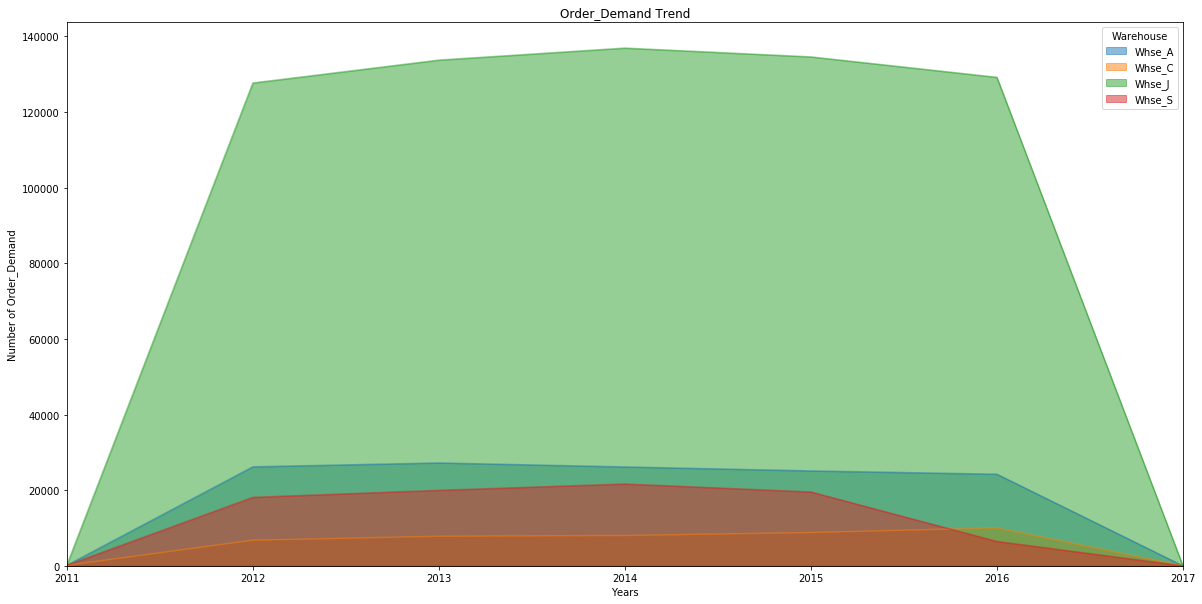

In [34]:
df3.index = df3.index.map(int) # index values of df3 to type integer for plotting
df3.plot(kind='area', stacked=False, figsize=(20, 10))

plt.title('Order_Demand Trend')
plt.ylabel('Number of Order_Demand')
plt.xlabel('Years')
plt.show()

### Grouping data by product code, product category, warehouse, date in months

In [35]:
df4 = df[['Product_Code','Product_Category','Warehouse','month_year','Order_Demand']].groupby(['Product_Code','Product_Category','Warehouse','month_year']).\
agg(['sum']).sort_values(by=['Product_Code','Product_Category','Warehouse','month_year'], ascending=True)

In [36]:
df4 = df4.reset_index()

In [37]:
df4.columns = df4.columns.droplevel(1)

In [38]:
df4.head(5)

,Product_Code,Product_Category,Warehouse,month_year,Order_Demand
0,Product_0001,Category_005,Whse_A,2012-01-01,6400
1,Product_0001,Category_005,Whse_A,2012-02-01,10400
2,Product_0001,Category_005,Whse_A,2012-03-01,11000
3,Product_0001,Category_005,Whse_A,2012-04-01,1500
4,Product_0001,Category_005,Whse_A,2012-05-01,8000


In [39]:
df4['Warehouse'].unique()

array(['Whse_A', 'Whse_J', 'Whse_C', 'Whse_S'], dtype=object)

### Prediction for Warehouse A

In [40]:
y_a = df4[['Product_Code','month_year','Order_Demand']][df4['Warehouse']=='Whse_A']

In [41]:
y_a.head(5)

,Product_Code,month_year,Order_Demand
0,Product_0001,2012-01-01,6400
1,Product_0001,2012-02-01,10400
2,Product_0001,2012-03-01,11000
3,Product_0001,2012-04-01,1500
4,Product_0001,2012-05-01,8000


In [42]:
y_a_top = y_a[['Product_Code','Order_Demand']].groupby('Product_Code').agg(['sum'])
y_a_top.columns = y_a_top.columns.droplevel(1)

In [43]:
y_a_top = y_a_top.reset_index().sort_values(by =['Order_Demand'], ascending=False).reset_index(drop=True)

In [44]:
y_a_top["% Contribution"] = y_a_top['Order_Demand']/y_a_top['Order_Demand'].sum()*100 
#contributions of each product in order demands for warehouse A

In [45]:
y_a_top.head(10)

,Product_Code,Order_Demand,% Contribution
0,Product_1496,10240750,7.145164
1,Product_1470,9035600,6.304309
2,Product_1388,7565300,5.278453
3,Product_0424,6073000,4.237247
4,Product_1513,5852300,4.083260
5,Product_1410,5360400,3.740052
6,Product_1299,4118400,2.873485
7,Product_0979,3561000,2.484577
8,Product_1825,3495000,2.438527
9,Product_0982,3273050,2.283669


#### Prediction for 'Product_1496'

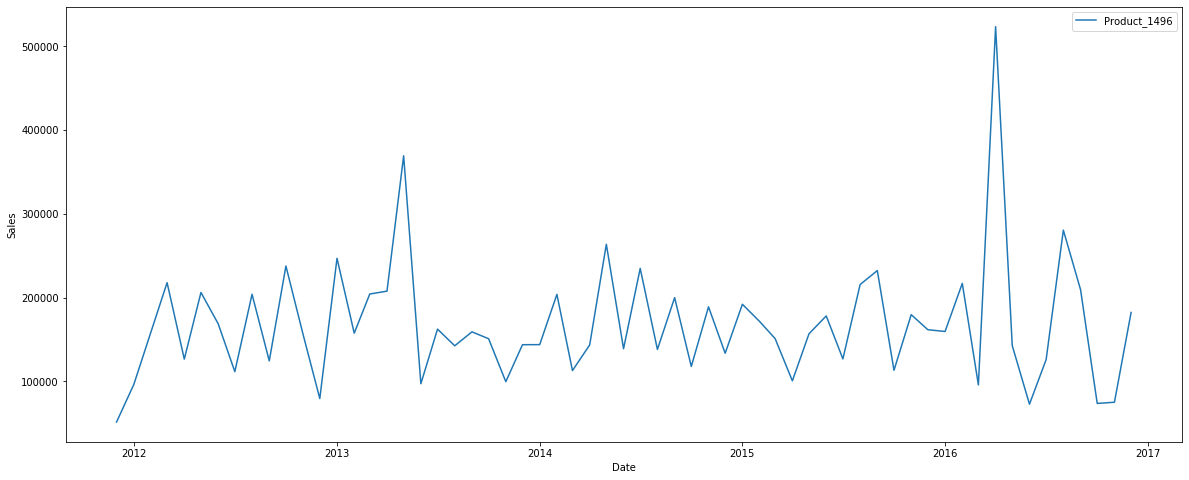

In [49]:
plt.figure(figsize=(20, 8))

code = 'Product_1496'
ts = y_a[y_a['Product_Code']==code].set_index('month_year')['Order_Demand']

plt.plot(y_a['month_year'][y_a['Product_Code']==code], y_a['Order_Demand'][y_a['Product_Code']==code],\
             label=code)
plt.xlabel('Date') 
plt.ylabel('Sales') 
plt.legend()


In [50]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

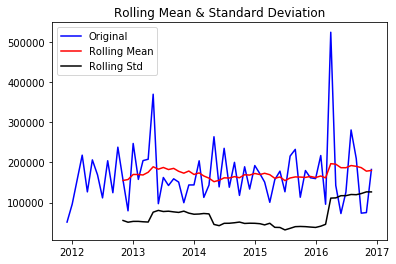

Results of Dickey-Fuller Test:
Test Statistic                -9.272184e+00
p-value                        1.317736e-15
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [51]:
test_stationarity(ts)

non-stationary time series

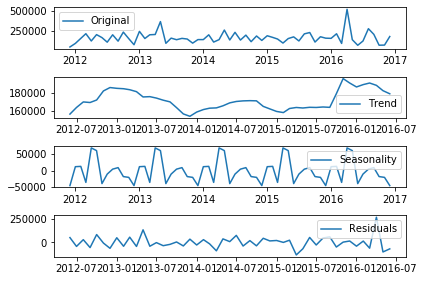

In [52]:
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [53]:
model = ARMA(ts[:-5], order=(0, 2))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(ts)-5, len(ts)-1)
print(yhat)

2016-08-01    186848.152173
2016-09-01    172729.243446
2016-10-01    169259.614408
2016-11-01    169259.614408
2016-12-01    169259.614408
Freq: MS, dtype: float64


C:\Users\Natalia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RMSE: 75272.1260')

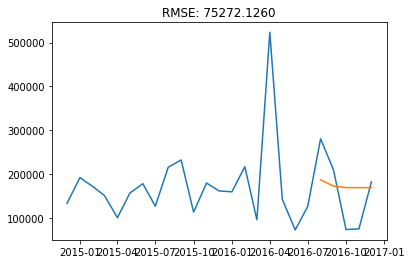

In [54]:
plt.plot(ts[-25:])
plt.plot(yhat)
plt.title('RMSE: %.4f'% np.sqrt(sum((yhat[-5:]-ts[-5:])**2)/len(ts[-5:])))

### Linear Regression

In [55]:
data_x = ts[:-5].index.astype(int)
data_y = ts[:-5]
regr = LinearRegression()
regr.fit(data_x.values.reshape(-1,1),data_y.values.reshape(-1,1))
x_for_pred = ts[-5:].index.astype(int)
y_pred = regr.predict(x_for_pred.values.reshape(-1,1)).flatten()
mae = sum(abs(y_pred - ts[-5:].values)) /ts[-5:].shape[0]
mse = mean_squared_error(ts[-5:],y_pred)


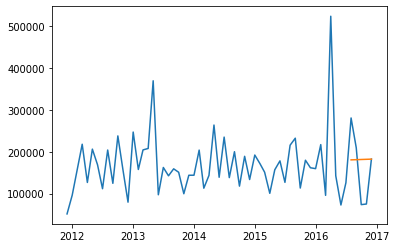

In [58]:
plt.plot(ts)
plt.plot(ts[-5:].index, y_pred)

In [59]:
print(mae,mse)

68633.26649059265 6770222599.640644


### Conclusion
We have tried to predict demand of product 'Product_1496' in warehouse A. It make sens to make prediction for each product in each warehouse because different location can cause different demand on products.
We tried two models ARMA and Linear Regression. For assessing performance of models RSME was used for ARMA model and MAE, MSE for Linear Regression. ARMA has RSME = 75272.1260 for testing 5 last months and Linear Regression has MSE = 6770222599.641. Comparing these two models, ARMA performs better but still prediction performs poor.